# Dropout as a Bayesian Approximation

In [1]:
import numpy as np
import pandas as pd
import time
from scipy.ndimage.interpolation import rotate

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

#import pymc3 as pm

In [2]:
def read_file(filename):
    with open(filename) as f:
        for line in f:
            yield line.strip().split(' ')

#df = pd.read_csv('/Users/shwetatiwari2601/Projects/dt8122/datasets/protein.txt', sep=' ', header=None, 
                 #names=['df1', 'df2', 'df3', 'df4', 'df5', 'df6', 'df7', 'df8', 'df9', 'df10'], index_col=False)
df = pd.read_csv('/Users/shwetatiwari2601/Projects/dt8122/datasets/power.txt', sep='\t', header=None, 
                 names=['df1', 'df2', 'df3', 'df4', 'df5'], index_col=False)
df.head()

,df1,df2,df3,df4,df5
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [51]:
df.shape

(9568, 5)

In [3]:
# Input features X
X = df.iloc[:, :4]
#X = df.iloc[:, :9]
# Target y
y = df.iloc[:, 4:]
#y = df.iloc[:, 9:]

In [4]:
# Splitting dataset into train and test set, test size = 10% of the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10)
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (8611, 4)
Shape of X_test: (957, 4)
Shape of y_train: (8611, 1)
Shape of y_test: (957, 1)


In [5]:
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [6]:
# Transform into tensors
X_train = torch.from_numpy(X_train.values)
y_train = torch.from_numpy(y_train.values)

In [7]:
print('X_train size:', X_train.size())
print('y_train size:', y_train.size())

X_train size: torch.Size([8611, 4])
y_train size: torch.Size([8611, 1])


In [11]:
'''
    nn.Module: is a base class for all modules, my module should be sub class of nn.Module class
    
    nn.Sequential: is a module container, modules are added in it in order they pass i the constructor
    
    ReLU is rectified linear unit y=max(0,x), activation function for a neural network layer, 
    ReLu is 0 for all the negative values
    
    Applies the element-wise tanh(x)=(e^x-e^-x)/(e^x+e^-x)
    
    nn.Linear: applies linear transformation to the incoming data. 
        Parameters:nn.Linear(in_features, out_features)
    
    nn.Dropout: During training, randomly zeroes some of the elements of the input tensor with probability p 
    using samples from a Bernoulli distribution. Each channel will be zeroed out independently on every 
    forward call. Furthermore, the outputs are scaled by a factor of 1/(1-p)during training. This means that  
    during evaluation the module simply computes an identity function. 
    parameters od nn.Dropout:
        p – probability of an element to be zeroed. Default: 0.5
        inplace – If set to True, will do this operation in-place. Default: False
        Input could be of any shape, output should be of same shape as Input
'''

class My_Network(nn.Module):    
    def __init__(self, hidden_layers, dropout_rate, activation_function):
        super(My_Network, self).__init__()
        self.model = nn.Sequential()
        #Adds a child module to the current module. The module can be accessed as an attribute using the given name.
        self.model.add_module('input', nn.Linear(4, hidden_layers[0])) 
        self.model.add_module('relu0', nn.ReLU())
        for i in range(len(hidden_layers)-1):
            self.model.add_module('dropout'+str(i+1), nn.Dropout(p=dropout_rate))# pytorch's inbuilt droupout
            self.model.add_module('hidden'+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            self.model.add_module('relu'+str(i+1), nn.ReLU())
        self.model.add_module('dropout'+str(i+2), nn.Dropout(p=dropout_rate))
        self.model.add_module('final', nn.Linear(hidden_layers[i+1], 1))
        
    def forward(self, x):
        return self.model(x)

In [32]:
class Regressor:
    def __init__(self, hidden_layers=[1024, 1024, 1024], dropout_rate=0.2, activation_function='relu', \
                 epoch=100, lr=0.0001, weight_decay=1e-6):
        self.model = My_Network(hidden_layers=hidden_layers, dropout_rate=dropout_rate, activation_function=activation_function)
        self.model.cpu()
        self.criterion = nn.MSELoss().cpu()
        self.epoch=epoch
        self.lr=lr
        self.weight_decay=weight_decay
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
    
    def fit(self, X_train, y_train, verbose=True):
        X = Variable(X_train)
        y = Variable(y_train)
        print(self.model)
        self.model.train()
        start_time = time.time()
        for epoch_i in range(self.epoch):
            epoch_i += 1
            epoch_loss = 0
            self.optimizer.zero_grad()
            net_out = self.model(X)
            loss = self.criterion(net_out, y)
            loss.backward()
            self.optimizer.step()
            epoch_loss += float(loss.data)
            epoch_loss /= len(X)
            if verbose:
                print(f'Epoch {epoch_i} | loss: {epoch_loss:.4f}')
        running_time = time.time() - start_time
        print('Running time in seconds:', running_time)
        return self
    

In [33]:
# Define networks
net = [Regressor(activation_function='relu')]
        
# Training, set verbose=True to see loss after each epoch.
[n.fit(X_train, y_train, verbose=True) for n in net]

# Save torch models
for i, mod in enumerate(net):
    torch.save(mod.model, '/Users/shwetatiwari2601/Projects/dt8122/results/power_dropout_100epoc'+str(i)+'.pth')

My_Network(
  (model): Sequential(
    (input): Linear(in_features=4, out_features=1024, bias=True)
    (relu0): ReLU()
    (dropout1): Dropout(p=0.2)
    (hidden1): Linear(in_features=1024, out_features=1024, bias=True)
    (relu1): ReLU()
    (dropout2): Dropout(p=0.2)
    (hidden2): Linear(in_features=1024, out_features=1024, bias=True)
    (relu2): ReLU()
    (dropout3): Dropout(p=0.2)
    (final): Linear(in_features=1024, out_features=1, bias=True)
  )
)
Epoch 1 | loss: 26.5012
Epoch 2 | loss: 18.2864
Epoch 3 | loss: 11.7001
Epoch 4 | loss: 6.6206
Epoch 5 | loss: 2.8855
Epoch 6 | loss: 0.6880
Epoch 7 | loss: 0.1774
Epoch 8 | loss: 1.2424
Epoch 9 | loss: 2.7029
Epoch 10 | loss: 3.2837
Epoch 11 | loss: 3.0137
Epoch 12 | loss: 2.2197
Epoch 13 | loss: 1.3523
Epoch 14 | loss: 0.6604
Epoch 15 | loss: 0.2641
Epoch 16 | loss: 0.1310
Epoch 17 | loss: 0.1932
Epoch 18 | loss: 0.3682
Epoch 19 | loss: 0.5640
Epoch 20 | loss: 0.7068
Epoch 21 | loss: 0.8042
Epoch 22 | loss: 0.8162
Epoch 23 | los

In [34]:
'''
    y_pred = prediction by dropout model
    y_hat_mc = prediction by dropout model using monte carlo sampling
'''
def predict_reg(model, X, T=1000):
    X = Variable(torch.from_numpy(X).type(torch.FloatTensor))
    model = model.train()
    y_hat_mc = np.array([model(X).data.cpu().numpy() for _ in range(T)]).squeeze() 
    model = model.eval() # only retrieved pre-trained model
    y_pred = model(X).data.cpu().numpy()
    model = model.train()# to set a flag( do not take pre-trained model)
    return y_pred, y_hat_mc

In [36]:
power_models = torch.load('/Users/shwetatiwari2601/Projects/dt8122/results/power_dropout_100epoc0.pth')
y_pred, y_hat_mc = predict_reg(power_models, X_test.values) 
y_pred_mc = y_hat_mc.mean(axis=0)
y_mc_std = y_hat_mc.std(axis=0)
results = [y_pred,y_pred_mc,y_mc_std]
results = [x.reshape(-1).astype(str).tolist() for x in results]
open("/Users/shwetatiwari2601/Projects/dt8122/results/power_results100.txt","w").write('\n'.join([','.join(res) for res in results]))

27859

In [37]:
RMSE = np.sqrt(np.mean((y_pred - y_test.values)**2))
RMSE

27.923414

In [38]:
import scipy.stats
def pred_interval(y_true, y_pred, quantile):  # z = significance level of 95%, which is the Gaussian critical value of 1.96.
    z = scipy.stats.norm.ppf(quantile)
    sum_err = np.sum((y_true - y_pred) ** 2)
    stdev = np.sqrt(1/(len(y_true) - 2) * sum_err)
    interval = z * stdev
    return interval

In [39]:
interval = pred_interval(y_test.values, y_pred, .95)
interval

45.977998845724585

In [40]:
lower = y_pred - interval
upper = y_pred + interval

In [41]:
print(upper[1], y_pred[1], lower[1])

[476.27948] [430.30148] [384.3235]


In [42]:
results = pd.DataFrame(index=y_test.index)
results['y_true'] = y_test.values
results['y_pred'] = y_pred
results['y_lower'] = lower
results['y_upper'] = upper
results = results.reset_index(drop=True)
results.head()

,y_true,y_pred,y_lower,y_upper
0,456.649994,430.902954,384.924957,476.880951
1,436.799988,430.301483,384.323486,476.279480
2,462.029999,433.411957,387.433960,479.389954
3,453.049988,431.418030,385.440033,477.396027
4,479.559998,436.002869,390.024872,481.980865


In [43]:
print(y_pred.max(), y_pred.min(), y_test.values.max(), y_test.values.min())

439.55408 423.17303 494.39 425.21


In [44]:
def picp(y_true, y_lower, y_upper):
    x = []
    for y, lo, up in zip(y_true, y_lower, y_upper):
        condition = ((lo < y) & (y < up))
        if condition:
            value = 1
        else:
            value = 0
        x.append(value)
    result = np.sum(x) / float(len(x))
    return result

In [45]:
def mpiw(y_lower, y_upper):
    result = (y_upper - y_lower).mean()
    return result

In [46]:
PICP = picp(y_test.values, lower, upper)
MPIW = mpiw(lower, upper)
RMSE = np.sqrt(np.mean((y_pred - y_test.values)**2))
print('RMSE = ', RMSE)
print('PICP = ', PICP)
print('MIPW = ', MPIW)

RMSE =  27.923414
PICP =  0.9070010449320794
MIPW =  91.95601


In [49]:
import matplotlib.pyplot as plt
def plot_prediction_intervals(data, y_true_label='y_true',  y_pred_label='y_pred', 
                              y_lower_label='y_lower', y_upper_label='y_upper',
                              figsize=(20,5)):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(data[[y_true_label]], color='green', linestyle='solid')
    ax.plot(data[[y_pred_label]], color='blue', linestyle='dotted')
    ax.fill_between(data.index, data[y_lower_label], data[y_upper_label], 
                    label='prediction interval', color='grey')

#     ax.set_xlim([0, len(data) -1 ])

    ax.set_xlabel('Index')
    ax.set_ylabel('Values')
    ax.set_title('Predictions generated by Bayesian dropout approximation')
    ax.legend(['Ground Truth', 'Point Prediction', 'Prediction Interval'], loc=2)
	
    plt.close()
    return fig

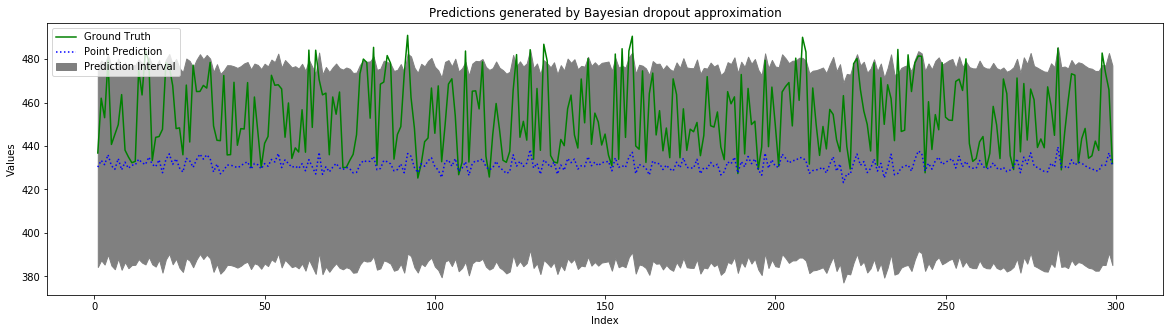

In [50]:
plot_prediction_intervals(results[1:300])